# wsae-lstm
Source article:
- https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0180944

Source article raw data:
- https://figshare.com/articles/Raw_Data/5028110

In [62]:
# Data preprocessing

In [63]:
# Imports (External)
import numpy as np
import pandas as pd
import datetime as dt

from collections import OrderedDict
import xlrd
import xlsxwriter
import copy
    # copy.deepcopy - needed for non-shallow copy of odict object

# Visualization/plotting imports
import matplotlib as mpl
import matplotlib.pyplot as plt

# Machine learning imports
import sklearn
import tensorflow as tf
import keras

import pywt
from scipy import signal

In [64]:
# Imports (Internal)

In [65]:
# Clean data import
    # Load in excel file and map each excel sheet to an ordered dict
    
raw_xlsx_file = pd.ExcelFile("data/clean_data.xlsx")
dict_dataframes =pd.read_excel(raw_xlsx_file,sheet_name = None)

In [66]:
print("\n".join(list(dict_dataframes.keys())))

csi300 index data
csi300 index future data
nifty 50 index data
nifty 50 index future data
hangseng index data
hangseng index future data
nikkei 225 index data
nikkei 225 index future data
s&p500 index data
s&p500 index future data
djia index data
djia index future data


In [ ]:
#Fig 7. Continuous dataset arrangement for training, validating and testing during the whole sample period:

#![fig%207%20dataset%20arrangement%20for%20train%20validate%20test.PNG](attachment:fig%207%20dataset%20arrangement%20for%20train%20validate%20test.PNG)

In [ ]:
#Table 2. Time interval of the six prediction years
#![table%202%20time%20interval%20of%206%20six%20year%20prediction.PNG](attachment:table%202%20time%20interval%20of%206%20six%20year%20prediction.PNG)

Model inputs:

1. Microeconomic variables 
    - OHLC data (Panel A)
    - Technicator indicators (Panel B)
3. Macroeconomic variables 
    - US Dollar Index, HIBOR (Panel C)

**Panel A variables:** 
- OHLC, H/L price, volume

**Panel B variables:**
- MACD, CCI, ATR, BOLL, EMA20, MA5/MA10, MTM5/MTM12, ROC, SMI, WVAD

**Panel C variables:**
- US Dollar Index, HIBOR 

Panel A variables (OHLC) and Panel B variables (Technical Indicators) can all be calculated/recreated for bitcoin and other crypto (or even stocks/forex)

Panel C variables (Exchange rate and Interest rates) are macroeconomic variables I'd have to find a replacement, substitute, or rough equivalent (if possible) for crypto, possibly even something like the stablecoin exchange premium or overall marketcap per currency/ticker

In [67]:
#dict_dataframes.keys()
print("\n".join(list(dict_dataframes.keys())))

csi300 index data
csi300 index future data
nifty 50 index data
nifty 50 index future data
hangseng index data
hangseng index future data
nikkei 225 index data
nikkei 225 index future data
s&p500 index data
s&p500 index future data
djia index data
djia index future data


In [68]:
# Create new dict of dataframes for futures
dict_dataframes_future =  copy.deepcopy(dict_dataframes)
# Create new dict of dataframes for index data
dict_dataframes_index =  copy.deepcopy(dict_dataframes)

In [69]:
# Remove index data from futures dict of dataframes
del dict_dataframes_future['csi300 index data']
del dict_dataframes_future['nifty 50 index data']
del dict_dataframes_future['hangseng index data']
del dict_dataframes_future['s&p500 index data']
del dict_dataframes_future['nikkei 225 index data']
del dict_dataframes_future['djia index data']

print("\n".join(list(dict_dataframes_future.keys())))

csi300 index future data
nifty 50 index future data
hangseng index future data
nikkei 225 index future data
s&p500 index future data
djia index future data


In [70]:
# Remove futures data from index dict of dataframes
del dict_dataframes_index['csi300 index future data']
del dict_dataframes_index['nifty 50 index future data']
del dict_dataframes_index['hangseng index future data']
del dict_dataframes_index['s&p500 index future data']
del dict_dataframes_index['nikkei 225 index future data']
del dict_dataframes_index['djia index future data']

print("\n".join(list(dict_dataframes_index.keys())))

csi300 index data
nifty 50 index data
hangseng index data
nikkei 225 index data
s&p500 index data
djia index data


In [71]:
dict_dataframes_future.keys()

odict_keys(['csi300 index future data', 'nifty 50 index future data', 'hangseng index future data', 'nikkei 225 index future data', 's&p500 index future data', 'djia index future data'])

In [72]:
dict_dataframes_index.keys()

odict_keys(['csi300 index data', 'nifty 50 index data', 'hangseng index data', 'nikkei 225 index data', 's&p500 index data', 'djia index data'])

In [73]:
# Visual analysis of data before train/test/split

In [74]:
dict_dataframes_index['csi300 index data'].head()

,date,open,high,low,close,volume,us dollar index,shibor,macd,cci,atr,boll,ema20,ma10,mtm6,ma5,mtm12,roc,smi,wvad
0,20080701,2799.20,2809.38,2690.18,2698.35,288515.85,72.34,2.5006,-213.078565,-128.949052,119.200,3173.475692,3033.748201,2851.2504,-91.594,2851.3262,-280.770,-9.424605,-0.097927,-8.726278e+07
1,20080702,2702.63,2745.94,2670.06,2699.60,279163.65,71.99,2.7238,-213.732249,-139.719688,75.875,3140.413385,3001.924277,2822.0828,-152.318,2797.3382,-252.645,-8.557733,-0.026497,-1.095493e+08
2,20080703,2654.48,2807.68,2617.26,2760.61,456603.05,72.73,2.5762,-206.941406,-112.113057,190.424,3109.044731,2978.942155,2820.8364,-208.925,2753.2792,-82.064,-2.886857,-0.031251,-5.855737e+07
3,20080704,2751.21,2783.85,2716.02,2741.85,379050.10,72.71,2.5632,-200.759162,-81.997539,67.825,3073.107115,2956.362140,2810.0548,-239.055,2738.4454,-249.421,-8.338289,-0.017237,-7.467503e+07
4,20080707,2747.61,2890.99,2747.61,2882.76,527320.24,72.71,2.5679,-182.386907,21.707767,149.133,3046.256923,2949.352699,2819.3370,66.742,2756.6342,109.687,3.955427,0.010701,-3.531151e+07


In [75]:
# Convert date column to datetime object for matplotlib
dict_dataframes_index['csi300 index data']['date'] = pd.to_datetime(dict_dataframes_index['csi300 index data']['date'].astype(str), format='%Y%m%d')
# Set date as index
dict_dataframes_index['csi300 index data'] = dict_dataframes_index['csi300 index data'].set_index('date')

In [76]:
dict_dataframes_index['csi300 index data'].head()

,open,high,low,close,volume,us dollar index,shibor,macd,cci,atr,boll,ema20,ma10,mtm6,ma5,mtm12,roc,smi,wvad
date,,,,,,,,,,,,,,,,,,,
2008-07-01,2799.20,2809.38,2690.18,2698.35,288515.85,72.34,2.5006,-213.078565,-128.949052,119.200,3173.475692,3033.748201,2851.2504,-91.594,2851.3262,-280.770,-9.424605,-0.097927,-8.726278e+07
2008-07-02,2702.63,2745.94,2670.06,2699.60,279163.65,71.99,2.7238,-213.732249,-139.719688,75.875,3140.413385,3001.924277,2822.0828,-152.318,2797.3382,-252.645,-8.557733,-0.026497,-1.095493e+08
2008-07-03,2654.48,2807.68,2617.26,2760.61,456603.05,72.73,2.5762,-206.941406,-112.113057,190.424,3109.044731,2978.942155,2820.8364,-208.925,2753.2792,-82.064,-2.886857,-0.031251,-5.855737e+07
2008-07-04,2751.21,2783.85,2716.02,2741.85,379050.10,72.71,2.5632,-200.759162,-81.997539,67.825,3073.107115,2956.362140,2810.0548,-239.055,2738.4454,-249.421,-8.338289,-0.017237,-7.467503e+07
2008-07-07,2747.61,2890.99,2747.61,2882.76,527320.24,72.71,2.5679,-182.386907,21.707767,149.133,3046.256923,2949.352699,2819.3370,66.742,2756.6342,109.687,3.955427,0.010701,-3.531151e+07


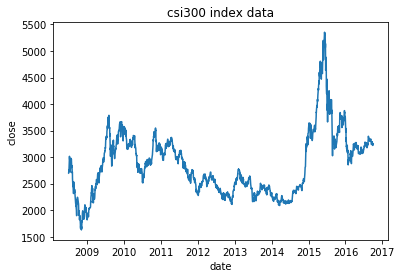

In [79]:
plt.title('csi300 index data')
plt.plot(dict_dataframes_index['csi300 index data'].index,dict_dataframes_index['csi300 index data']['close'])
plt.ylabel('close')
plt.xlabel('date')
plt.show()

In [80]:
# scikit-learn data preprocess

In [81]:
# Index value for train test split check
X=dict_dataframes['csi300 index data'].values
X

array([[ 2.00807010e+07,  2.79920000e+03,  2.80938000e+03, ...,
        -9.42460467e+00, -9.79268693e-02, -8.72627838e+07],
       [ 2.00807020e+07,  2.70263000e+03,  2.74594000e+03, ...,
        -8.55773341e+00, -2.64972904e-02, -1.09549319e+08],
       [ 2.00807030e+07,  2.65448000e+03,  2.80768000e+03, ...,
        -2.88685731e+00, -3.12513598e-02, -5.85573695e+07],
       ...,
       [ 2.01609280e+07,  3.24364700e+03,  3.24364700e+03, ...,
        -3.25412539e+00, -9.03054995e-03, -1.52809487e+08],
       [ 2.01609290e+07,  3.23485700e+03,  3.25776680e+03, ...,
        -2.21988015e+00,  1.74378066e-03, -8.96478826e+07],
       [ 2.01609300e+07,  3.24017750e+03,  3.26094050e+03, ...,
        -2.85646040e-01, -3.01533114e-03, -4.81545298e+07]])

In [82]:
#print("\n".join(list(dict_dataframes_index['csi300 index data'].columns)))
dict_dataframes_index['csi300 index data'].columns

Index(['open', 'high', 'low', 'close', 'volume', 'us dollar index', 'shibor',
       'macd', 'cci', 'atr', 'boll', 'ema20', 'ma10', 'mtm6', 'ma5', 'mtm12',
       'roc', 'smi', 'wvad'],
      dtype='object')

In [83]:
pd.DataFrame(X).head()
# Column 0 is index/datetime index
# Columns 1-19 are the features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,20080701.0,2799.20,2809.38,2690.18,2698.35,288515.85,72.34,2.5006,-213.078565,-128.949052,119.200,3173.475692,3033.748201,2851.2504,-91.594,2851.3262,-280.770,-9.424605,-0.097927,-8.726278e+07
1,20080702.0,2702.63,2745.94,2670.06,2699.60,279163.65,71.99,2.7238,-213.732249,-139.719688,75.875,3140.413385,3001.924277,2822.0828,-152.318,2797.3382,-252.645,-8.557733,-0.026497,-1.095493e+08
2,20080703.0,2654.48,2807.68,2617.26,2760.61,456603.05,72.73,2.5762,-206.941406,-112.113057,190.424,3109.044731,2978.942155,2820.8364,-208.925,2753.2792,-82.064,-2.886857,-0.031251,-5.855737e+07
3,20080704.0,2751.21,2783.85,2716.02,2741.85,379050.10,72.71,2.5632,-200.759162,-81.997539,67.825,3073.107115,2956.362140,2810.0548,-239.055,2738.4454,-249.421,-8.338289,-0.017237,-7.467503e+07
4,20080707.0,2747.61,2890.99,2747.61,2882.76,527320.24,72.71,2.5679,-182.386907,21.707767,149.133,3046.256923,2949.352699,2819.3370,66.742,2756.6342,109.687,3.955427,0.010701,-3.531151e+07


In [84]:
# Drop date from dataframe - use index values to reconcile later
dict_dataframes['csi300 index data'].drop(['date'],axis=1,inplace=True)

In [85]:
dict_dataframes['csi300 index data'].head()

,open,high,low,close,volume,us dollar index,shibor,macd,cci,atr,boll,ema20,ma10,mtm6,ma5,mtm12,roc,smi,wvad
0,2799.20,2809.38,2690.18,2698.35,288515.85,72.34,2.5006,-213.078565,-128.949052,119.200,3173.475692,3033.748201,2851.2504,-91.594,2851.3262,-280.770,-9.424605,-0.097927,-8.726278e+07
1,2702.63,2745.94,2670.06,2699.60,279163.65,71.99,2.7238,-213.732249,-139.719688,75.875,3140.413385,3001.924277,2822.0828,-152.318,2797.3382,-252.645,-8.557733,-0.026497,-1.095493e+08
2,2654.48,2807.68,2617.26,2760.61,456603.05,72.73,2.5762,-206.941406,-112.113057,190.424,3109.044731,2978.942155,2820.8364,-208.925,2753.2792,-82.064,-2.886857,-0.031251,-5.855737e+07
3,2751.21,2783.85,2716.02,2741.85,379050.10,72.71,2.5632,-200.759162,-81.997539,67.825,3073.107115,2956.362140,2810.0548,-239.055,2738.4454,-249.421,-8.338289,-0.017237,-7.467503e+07
4,2747.61,2890.99,2747.61,2882.76,527320.24,72.71,2.5679,-182.386907,21.707767,149.133,3046.256923,2949.352699,2819.3370,66.742,2756.6342,109.687,3.955427,0.010701,-3.531151e+07


In [86]:
# Splitting data this particular way includes the previous observations into the next training set (TimeSeriesSplit)

from sklearn.model_selection import TimeSeriesSplit

train_list = []
test_list = []
X = dict_dataframes['csi300 index data'].values

splits = TimeSeriesSplit(n_splits=6)
index = 1
for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    train_list.append(train)
    test_list.append(test)
    index += 1

Observations: 575
Training Observations: 288
Testing Observations: 287
Observations: 862
Training Observations: 575
Testing Observations: 287
Observations: 1149
Training Observations: 862
Testing Observations: 287
Observations: 1436
Training Observations: 1149
Testing Observations: 287
Observations: 1723
Training Observations: 1436
Testing Observations: 287
Observations: 2010
Training Observations: 1723
Testing Observations: 287


In [87]:
len(train_list),len(test_list)

(6, 6)

In [ ]:
#Fig 1. The flowchart of the proposed deep learning framework for financial time series
#![fig%201%20flowchart%20of%20dl%20framework%20model.PNG](attachment:fig%201%20flowchart%20of%20dl%20framework%20model.PNG)

**As defined by bao-yue-rao, the WSAE-LSTM model has three primary components:**

1. Wavelet transform applied to denoise data as part of preprocessing
2. Stacked Autoencoders to generate high level features
3. LSTMs to forecast next day closing price

**Wavelet Transform**

"As a result, the two-level wavelet is applied twice in this study for data preprocessing as suggested in [23]"

"First, the denoised time series is generated via discrete wavelet transform using the Haar wavelet"

"This study applies the Haar function as the wavelet basis function because it can not only decompose the financial time series into time and frequency domain but also reduce the processing time significantly [23]"

In [88]:
# Single-level wavelet transform
    # https://pywavelets.readthedocs.io/en/latest/ref/dwt-discrete-wavelet-transform.html
#cA, cD = pywt.dwt(clean_data.values, 'haar')

In [89]:
dict_dataframes['csi300 index data'].head()

,open,high,low,close,volume,us dollar index,shibor,macd,cci,atr,boll,ema20,ma10,mtm6,ma5,mtm12,roc,smi,wvad
0,2799.20,2809.38,2690.18,2698.35,288515.85,72.34,2.5006,-213.078565,-128.949052,119.200,3173.475692,3033.748201,2851.2504,-91.594,2851.3262,-280.770,-9.424605,-0.097927,-8.726278e+07
1,2702.63,2745.94,2670.06,2699.60,279163.65,71.99,2.7238,-213.732249,-139.719688,75.875,3140.413385,3001.924277,2822.0828,-152.318,2797.3382,-252.645,-8.557733,-0.026497,-1.095493e+08
2,2654.48,2807.68,2617.26,2760.61,456603.05,72.73,2.5762,-206.941406,-112.113057,190.424,3109.044731,2978.942155,2820.8364,-208.925,2753.2792,-82.064,-2.886857,-0.031251,-5.855737e+07
3,2751.21,2783.85,2716.02,2741.85,379050.10,72.71,2.5632,-200.759162,-81.997539,67.825,3073.107115,2956.362140,2810.0548,-239.055,2738.4454,-249.421,-8.338289,-0.017237,-7.467503e+07
4,2747.61,2890.99,2747.61,2882.76,527320.24,72.71,2.5679,-182.386907,21.707767,149.133,3046.256923,2949.352699,2819.3370,66.742,2756.6342,109.687,3.955427,0.010701,-3.531151e+07


In [90]:
len(train_list),len(test_list)

(6, 6)

In [144]:
train_list[0]

array([[ 2.79920000e+03,  2.80938000e+03,  2.69018000e+03, ...,
        -9.42460467e+00, -9.79268693e-02, -8.72627838e+07],
       [ 2.70263000e+03,  2.74594000e+03,  2.67006000e+03, ...,
        -8.55773341e+00, -2.64972904e-02, -1.09549319e+08],
       [ 2.65448000e+03,  2.80768000e+03,  2.61726000e+03, ...,
        -2.88685731e+00, -3.12513598e-02, -5.85573695e+07],
       ...,
       [ 3.14957000e+03,  3.21227000e+03,  3.11689000e+03, ...,
        -1.12494886e+01, -5.62604688e-02, -4.88211696e+07],
       [ 3.15204000e+03,  3.16819000e+03,  3.03073000e+03, ...,
        -1.03202155e+01, -2.97713159e-02, -2.31053336e+08],
       [ 3.00354000e+03,  3.00354000e+03,  2.82577000e+03, ...,
        -1.77442877e+01, -1.07729038e-01, -3.42461309e+08]])

In [145]:
train_list[0].shape

(288, 19)

In [146]:
pd.DataFrame(train_list[0]).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,2799.20,2809.38,2690.18,2698.35,288515.85,72.34,2.5006,-213.078565,-128.949052,119.200,3173.475692,3033.748201,2851.2504,-91.594,2851.3262,-280.770,-9.424605,-0.097927,-8.726278e+07
1,2702.63,2745.94,2670.06,2699.60,279163.65,71.99,2.7238,-213.732249,-139.719688,75.875,3140.413385,3001.924277,2822.0828,-152.318,2797.3382,-252.645,-8.557733,-0.026497,-1.095493e+08
2,2654.48,2807.68,2617.26,2760.61,456603.05,72.73,2.5762,-206.941406,-112.113057,190.424,3109.044731,2978.942155,2820.8364,-208.925,2753.2792,-82.064,-2.886857,-0.031251,-5.855737e+07
3,2751.21,2783.85,2716.02,2741.85,379050.10,72.71,2.5632,-200.759162,-81.997539,67.825,3073.107115,2956.362140,2810.0548,-239.055,2738.4454,-249.421,-8.338289,-0.017237,-7.467503e+07
4,2747.61,2890.99,2747.61,2882.76,527320.24,72.71,2.5679,-182.386907,21.707767,149.133,3046.256923,2949.352699,2819.3370,66.742,2756.6342,109.687,3.955427,0.010701,-3.531151e+07


In [150]:
test_list[0]

array([[ 2.80458000e+03,  2.90128000e+03,  2.79549000e+03, ...,
        -1.49728716e+01, -5.66807582e-02, -2.18026729e+08],
       [ 2.82464000e+03,  2.90479000e+03,  2.81362000e+03, ...,
        -7.94023828e+00, -8.06083215e-02, -2.18063203e+08],
       [ 2.89845000e+03,  3.05999000e+03,  2.89265000e+03, ...,
        -3.78381241e+00, -4.73401373e-02, -2.17586935e+08],
       ...,
       [ 3.53419000e+03,  3.54931000e+03,  3.50638000e+03, ...,
         5.15251053e+00,  2.32437554e-02,  7.57064128e+08],
       [ 3.54744000e+03,  3.54744000e+03,  3.49862000e+03, ...,
         4.30049828e+00,  3.40759272e-02,  7.01482336e+08],
       [ 3.50720000e+03,  3.50828000e+03,  3.47097000e+03, ...,
         5.17942559e-01,  2.89842191e-02,  6.13802591e+08]])

In [148]:
# Not working due to lack of datetime index from/in dataframe format

# plt.title("Train/Test[0] split for csi300 index data")
# plt.xlabel("date")
# plt.ylabel("close")
# plt.plot(train_list[0],'orange')
# plt.plot(test_list[0],'purple')

In [95]:
# Multi-level wavelet transform
    # https://pywavelets.readthedocs.io/en/latest/ref/dwt-discrete-wavelet-transform.html#pywt.wavedec
from pywt import wavedec
coeffs = wavedec(train_list[0], 'haar', level=2)
cA2, cD2, cD1 = coeffs
#print(coeffs)
# cA = Approximation coefficients
# cD = Detail coefficient(s)

In [96]:
# Single-level wavelet transform
    # https://pywavelets.readthedocs.io/en/latest/ref/dwt-discrete-wavelet-transform.html
#cA, cD = pywt.dwt(data, 'haar')

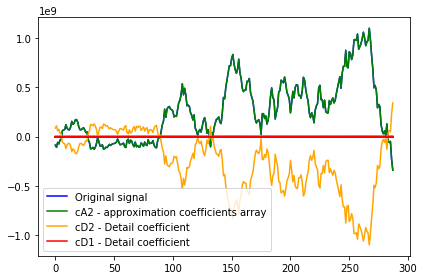

In [102]:
plt.plot(train_list[0],'blue', label='Original signal')
plt.plot(cA2,'green',label='cA2 - approximation coefficients array')
plt.plot(cD2,'orange',label= 'cD2 - Detail coefficient')
plt.plot(cD1,'red',label = 'cD1 - Detail coefficient')

# Remove duplicate lables when calling plt.legend() with multiple subplots
    # Source: https://stackoverflow.com/a/13589144
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.tight_layout()
plt.show()

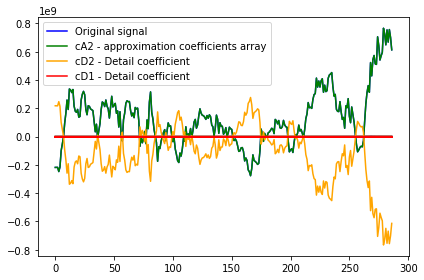

In [113]:

coeffs = wavedec(test_list[0], 'haar', level=2)
cA2, cD2, cD1 = coeffs
plt.plot(test_list[0],'blue', label='Original signal')
plt.plot(cA2,'green',label='cA2 - approximation coefficients array')
plt.plot(cD2,'orange',label= 'cD2 - Detail coefficient')
plt.plot(cD1,'red',label = 'cD1 - Detail coefficient')

# Remove duplicate lables when calling plt.legend() with multiple subplots
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.tight_layout()
plt.show()

In [53]:
import pywt
from statsmodels.robust import mad
import numpy as np

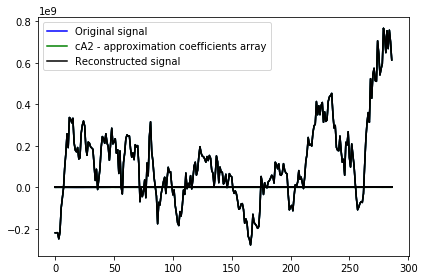

In [115]:
def wavelet_reconst_l2(data):
    coeffs = wavedec(data, 'haar', level=2)
    cA2, cD2, cD1 = coeffs
    reconstructed_signal = pywt.waverec( coeffs, 'haar', mode = 'per')
    return reconstructed_signal
 
test_list_0_reconstructed = wavelet_reconst_l2(test_list[0])

plt.plot(test_list[0],'blue', label='Original signal')
plt.plot(cA2,'green',label='cA2 - approximation coefficients array')
#plt.plot(cD2,'orange',label= 'cD2 - Detail coefficient')
#plt.plot(cD1,'red',label = 'cD1 - Detail coefficient')
plt.plot(test_list_0_reconstructed,'black',label='Reconstructed signal')

# Remove duplicate lables when calling plt.legend() with multiple subplots
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.tight_layout()
plt.show()

In [116]:
len(cA2),len(cD2),len(cD1)

(287, 287, 287)

In [152]:
# def wavelet_reconst_l2_threshold(data):
#     coeffs = wavedec(data, 'haar', level=2)
#     cA2, cD2, cD1 = coeffs
#     reconstructed_signal = pywt.waverec( coeffs, 'haar', mode = 'per')
#     return reconstructed_signal

#     cat = pywt.threshold(cA2, np.std(cA2)/2,mode='soft')
#     cdt = pywt.threshold(cD2, np.std(cD2)/2,mode='soft')
#     ts_rec = pywt.idwt(cat, cdt, 'haar')
#     return ts_rec

# NOTE: Above func is not working - check variable scope ?

cat = pywt.threshold(cA2, np.std(cA2)/2,mode='soft')
cdt = pywt.threshold(cD2, np.std(cD2)/2,mode='soft')
ts_rec = pywt.idwt(cat, cdt, 'haar')

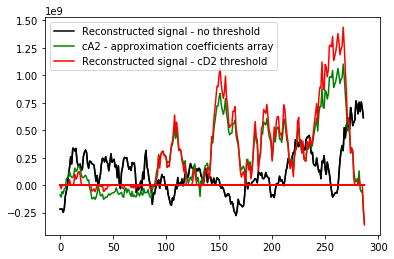

In [174]:
#plt.plot(test_list[0],'blue', label='Original signal')
plt.plot(test_list_0_reconstructed,'black',label='Reconstructed signal - no threshold')
plt.plot(cA2,'green',label='cA2 - approximation coefficients array')
plt.plot(ts_rec, 'red',label='Reconstructed signal - cD2 threshold')
#plt.plot(cat,'blue')
#plt.plot(cdt,'orange')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
#plt.tight_layout()


In [121]:
coeffs = wavedec(train_list[0], 'haar', level=2)
cA2, cD2, cD1 = coeffs
cat = pywt.threshold(cA2, np.std(cA2)/2,mode='soft')
cdt = pywt.threshold(cD2, np.std(cD2)/2,mode='soft')

# Denoised train and test data
test_dn = ts_rec
train_dn = pywt.idwt(cat, cdt, 'haar')

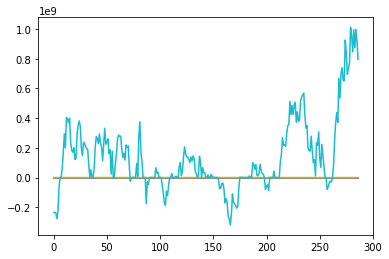

In [128]:
plt.plot(test_dn)

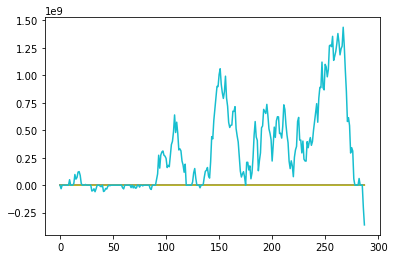

In [129]:
plt.plot(train_dn)

**Stacked Autoencoders**

SAE with 5 Layers that consists of 4-single layer autoencoders
- Input variables for each dataset range from 18-25 features
- Depth of 5, hidden layer size of 10
- Gradient descent

"The single-layer autoencoder maps the input daily variables into the first hidden vector."
"After training the first single-layer autoencoder, the reconstruction layer of the first single layer autoencoder is removed, and the hidden layer is reserved as the input layer of the second single-layer autoencoder"

In [158]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import optimizers

In [159]:
print(len(train_dn),len(test_dn))

288 287


In [163]:
train_dn.shape[0]

288

In [175]:
train_dn.shape[1]

10

In [171]:
encoding_dim = 10
input_placeholder = Input(shape=(train_dn.shape[0],))

encoded = Dense(encoding_dim * 4)(input_placeholder)
encoded = Dense(encoding_dim * 2)(encoded)
encoded = Dense(encoding_dim)(encoded)

decoded = Dense(encoding_dim * 2)(encoded)
decoded = Dense(encoding_dim * 4)(decoded)
decoded = Dense(train_dn.shape[0])(decoded)

autoencoder = Model(input_placeholder, decoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 288)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 40)                11560     
_________________________________________________________________
dense_33 (Dense)             (None, 20)                820       
_________________________________________________________________
dense_34 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_35 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_36 (Dense)             (None, 40)                840       
_________________________________________________________________
dense_37 (Dense)             (None, 288)               11808     
Total para